# Homework 2, Stat 271 

**NOTICE: You can work in group with up to three people.   
Submit one report for your team. Describe each member's contribution.**

(All code and data can be downloaded from https://github.com/qiuwch/Stat271HW/archive/master.zip)

If you find this ipython notebook is unclear or contains bugs, please contact qiuwch@gmail.com  
If there's an error says "something is undefined", please run cell which contains the definition or use "menu -> cell -> run all above"

# Foreground/background classification.

See [lecture note 3](http://www.stat.ucla.edu/~yuille/courses/Stat271-Fall14/lecture3.pdf) for more detail.


Here we consider a model for foreground/background classification so that it can include spatial context. Intuitively neighboring pixels in the image are likely to belong to the same class, i.e. are likely to be either all background or all foreground. This is a form of prior knowledge, or natural statistic, which can be learnt by analyzing natural images.

For pixel i, the foreground label is $ S_i = 1 $, and background label is $ S_i $ = -1.

The prior term encourages neighbouring pixels to have the same intensity:  
$ E_P[S] = \gamma \sum_{i} \sum_{j \in N(i)} { - S_i S_j} $ 

The data term is defined as:

$ E_d[S, I] = \eta \sum_{i} (I_i - S_i)^2 $


These two terms are combined to get the energy.

$ E(S) = E_p[S] + E_d[S, I] $

Then the posterior of the labeling S given the image I is

$ P(S|I) = \frac{1}{Z} exp( - \frac{E[S]}{T} ) $

The block of code below initializes the ipython notebook

In [1]:
# Initiialization code
%matplotlib inline
import numpy as np
from pylab import imshow, show, get_cmap, imread, figure, subplots, title, subplot
from numpy import random

The block of code below loads an image and convert it to range (-1, 1).

original range: 0.0 0.846330682811
remaped range: -1.0 1.0


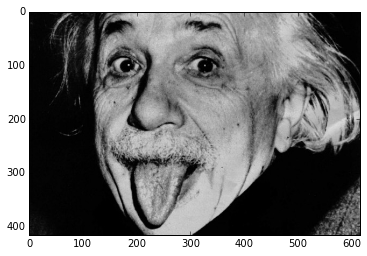

In [2]:
im = imread('../data/gibbs/gibbs_demo.jpg')
imshow(im)

def myimshow(state):
    imshow(state, interpolation='nearest')

# Preprocess image to range (-1, 1)
def preproc_data(im, scale=0.1, debug=False):
    import skimage.color
    import skimage.transform
    
    tinyim = skimage.transform.rescale(im, scale)
    grayim = skimage.color.rgb2gray(tinyim)

    # Linear map the data to -1, 1
    scale = grayim.max() - grayim.min()
    data = 2 * (grayim - grayim.min()) / scale - 1
    if debug:
        print 'original range:', grayim.min(), grayim.max()
        print 'remaped range:', data.min(), data.max()

    return [data, tinyim]

[data, im] = preproc_data(im, debug=True) # data is normalized image

The block of code below defines neighborhood structure for gibbs sampler.

In [3]:
def getneighor(y, x, h, w): # get 4-side neighbor
    n = []
    if (x != 0): n.append((y, x-1))
    if (x != w-1): n.append((y, x+1))
    if (y != 0): n.append((y-1, x))
    if (y != h-1): n.append((y+1, x))
    return n

def poslist(h,w):
    '''Get point list of a grid'''
    pos = []
    for x in range(w):
        for y in range(h):
            pos.append((y, x))
    return pos

The block of code below defines a utility function to compute energy.

In [7]:
def energy_prior(state, gamma):
    total = 0
    (h, w) = state.shape
    pos = poslist(h, w)
    for p in pos:
        neighbor = getneighor(p[0], p[1], h, w) # compute neighbor
        
        for n in neighbor:
            total += state[p[0]][p[1]] * state[n[0]][n[1]]
    E = - gamma * total / 2 # gamma is a global variable
    return E/2
        
def energy_data(state, data, eta):
    E = eta * sum((data - state)**2)
    return E

def energy(state, data, gamma, eta):
    return energy_prior(state, gamma) + energy_data(state, data, eta)

The block of code below defines the gibbs sampler.

In [8]:
def gibbs_sampler(state, data, gamma, eta, debug=False): # 0/1 state
    prob = 0
    # p(x_i| x_{-i}) = p(x_i, x_{-i})/p(x_{-i}), the analytical form?
    # exp(E(x_i))/ \sum exp(E(X_i))
    (h, w) = state.shape
    new_state = state.copy()
    pos = poslist(h, w)
    for p in pos:
        neighbor_pos = getneighor(p[0], p[1], h, w)
        neighbor_value = [new_state[n[0]][n[1]] for n in neighbor_pos]
        # neighbor_value = [state[n[0]][n[1]] for n in neighbor_pos]
        # sample
        tmp1 = -gamma * -1 * sum(neighbor_value) # x_i = -1
        tmp2 = -gamma * 1 * sum(neighbor_value) # x_i = 1
        
        # add data term
        v = data[p[0]][p[1]]
        tmp1 += eta * (v - (-1))**2 # x_i = -1
        tmp2 += eta * (v - 1)**2 #  x_i = -1
        
        tmp1 = np.exp(-tmp1)
        tmp2 = np.exp(-tmp2)

        p1 = tmp1 / (tmp1 + tmp2)
        prob = random.uniform() # roll a dice
        
        if (debug): print p1
        if (prob > p1):
            new_state[p[0]][p[1]] = 1
        else:
            new_state[p[0]][p[1]] = -1
    return new_state

# Animation: sample with data term included
Run this demo below

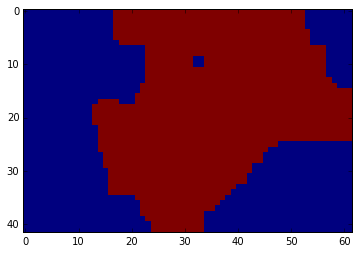

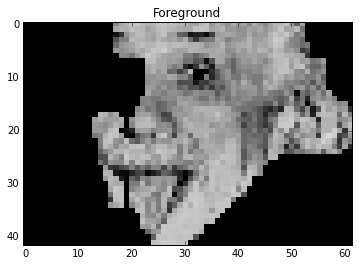

In [22]:
from IPython.display import display, clear_output
import time

random_seed = 1 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat
init_state = random_state

new_state = random_state.copy()
E = [energy(init_state, data, gamma=20, eta=1)]

f, ax = subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma=20, eta=1)

    # time.sleep(1)
    myimshow(new_state)
    display(f)

title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
imshow(fg, cmap='gray', interpolation='nearest')


# HW 2.1 Gibbs sampler
Set random_seed to a different value
1. Try different values of $ \gamma $, $ \eta $, including special case that only contains prior term. What happens when the parameters change?
2. Run with different images, plot your result. Find two or three images from web or your image collection.
3. When does the sampler converge for the Einstein image with $ \gamma = 20 $ and $ \eta = 1 $ and how do you know it?

# Answer of HW2.1

Q1: Try different values of $\gamma $, $\eta$, including special case that only contains prior term. What happens when the parameters change?

The prior term encourages neighbouring pixels to have the same intensity:

$$ E_p[S] = \gamma \sum_{i} \sum_{j \in N(i)} { - S_i S_j} $$

The data term is defined as:

$$ E_d[S, I] = \eta \sum_{i} (I_i - S_i)^2 $$

These two terms are combined to get the energy.

$$ E(S) = E_p[S] + E_d[S, I] $$

The $ \gamma $ controls the strength of the prior term and the $ \eta $ controls the strength of the data term.

We set random\_seed to 5. The parameters we tried are

- $ \eta = 0 $, $ \gamma = 20 $ (only contains prior term)
- $ \eta = 1 $, $ \gamma = 20 $ (the default parameter provided in homework specification)
- $ \eta = 1 $, $ \gamma = 1 $

In [14]:
from IPython.display import display, clear_output
import time

random_seed = 5 # Change this in your experiment
random.seed(random_seed)

def runGibbsSampler(data, gamma, eta, showAnimation=True):
    (h, w) = data.shape
    mat = random.random((h,w))
    mat[mat>0.5] = 1
    mat[mat<=0.5] = -1
    random_state = mat
    init_state = random_state

    new_state = random_state.copy()
    E = [energy(init_state, data, gamma=gamma, eta=eta)]
    
    if showAnimation:
        f, ax = subplots() # prepare animation
        
    for i in range(60):
        clear_output(wait=True)
        new_state = gibbs_sampler(new_state, data, gamma, eta)
        E.append(energy(new_state, data, gamma=gamma, eta=eta))
        # time.sleep(1)
        if showAnimation:
            myimshow(new_state)
            display(f)
        else:
            print 'iteration %d' % i

    return new_state

Animation of interations:
- $ \eta = 0, \gamma = 20 $ (only contains prior term) 

1) When $ \eta = 0 $, the Gibbs sampler will sample from a probability distribution with only prior term.

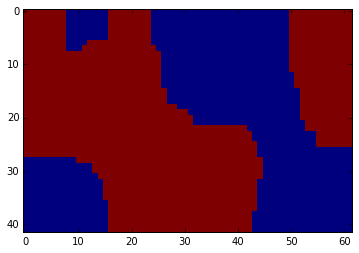

In [23]:
state = runGibbsSampler(data, eta=0, gamma=20)
clear_output()

Animation of interations:
- $ \gamma = 1 $, $ \eta = 20 $ (the default parameter provided in homework specification)

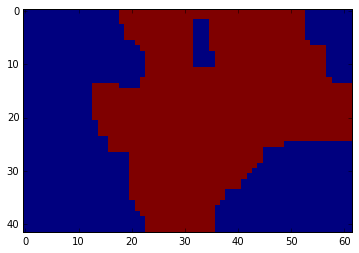

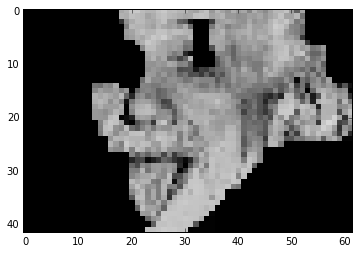

In [17]:
state = runGibbsSampler(data, eta=1, gamma=20)
mask = (state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
    
imshow(fg, cmap='gray', interpolation='nearest')

Animation of iterations:

- $ \gamma = 1 $, $ \eta = 1 $

In this case, we reduce $ \gamma $ from 20 to 1. From the result we can see, it is less smooth.

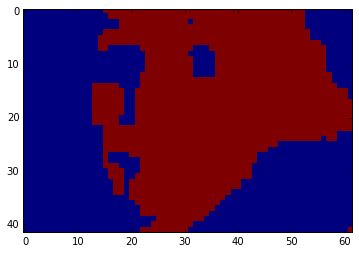

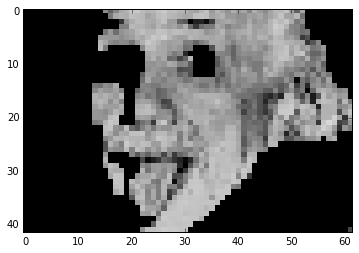

In [24]:
state = runGibbsSampler(data, eta=1, gamma=1)
mask = (state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
    
imshow(fg, cmap='gray', interpolation='nearest')

Q2. Run with different images and plot results.

iteration 59


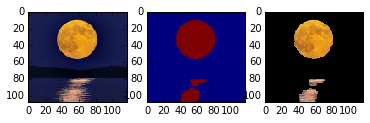

In [19]:
filename = '../data/gibbs/moon.jpg'

def fgBgSegmentation(filename):
    im = imread(filename)
    [data, im] = preproc_data(im, scale=0.5)
    state = runGibbsSampler(data, eta=1, gamma=1, showAnimation=False)

    mask = (state==1)
    fg = im.copy()
    for i in range(3): 
        fg[:,:,i] = fg[:,:,i] * mask

    subplot(1,3,1)
    imshow(im, interpolation='nearest')
    subplot(1,3,2)
    imshow(state)
    subplot(1,3,3)
    imshow(fg, interpolation='nearest')
    
fgBgSegmentation(filename)

iteration 59


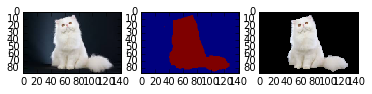

In [20]:
fgBgSegmentation('../data/gibbs/cat3.jpg')

iteration 59


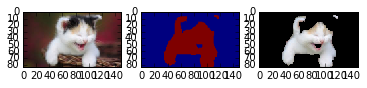

In [21]:
fgBgSegmentation('../data/gibbs/cat4.jpg')

# HW 2.2 Convolutional neural network

1. Train a deep convolutional neuron network on MNIST dataset with code from [MatConvNet](http://www.vlfeat.org/matconvnet/).   
The demo code examples/cnn_mnist.m contains everything you need, just run it.    
[Tutorial: Training your own models](http://www.vlfeat.org/matconvnet/#training)

2. Use trained model to do digit classification. In your report, include some digit images and their classification result. Show some misclassified digits.    

3. Include the network structure used for training and the train/validation error plot in the report.

Notice: The MatConvNet code runs in MATLAB, but you can also use [caffe](http://caffe.berkeleyvision.org) or other CNN implementation

<code>
% A snippet of MATLAB code to read images from MNIST dataset.    
% This code may be helpful for loading image for testing.    
f=fopen(fullfile('./data/mnist/t10k-images-idx3-ubyte'),'r') ;     
x2=fread(f,inf,'uint8');    
fclose(f) ;    
x2=permute(reshape(x2(17:end),28,28,10e3),[2 1 3]) ;    
    
i = 1;   
im = single(x2(:,:,i)) ;    
imagesc(im);    

% (HINT: last layer of the CNN is defined for training, remove it before you use the model in vl_simplenn)
</code>

<img src="../data/dbn/digit.png">
An example of digit classification